# Problem Statement

Green,a country well known for its greenery and natural resources, is working towards the betterment of the environment, natural resources, and health of citizens. Over the past few years, Green has improvised its natural resources by enabling the technologies for a safer future. 


The major investment happened to be in renewable energy. As of today, renewable energy contributes to 60% of the total energy capacity in the country. By 2030, the target is to generate 95% of the total energy through renewable energy.


In order to achieve this objective, the government of Green Energy would like to use Data Science to understand the total energy demand of the country in the near future. This will help the government to build the infrastructure and technologies to achieve 95% of the total energy capacity via renewable energy.


They have captured the estimated total energy demand from the past 12 years on an hourly basis. Now, the government of Green Energy is looking for a data scientist to understand the data and forecast the total energy demand for the next 3 years based on past trends.



##  Objective
 To build a machine learning/deep learning approach to forecast the total energy demand on an hourly basis for the next 3 years based on past trends.


## 1. Importing libraries

In [1]:
# importing all the required libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from datetime import datetime, timedelta
# Import regression and error metrics modules
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score


# Importing time series split for cross validation 
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.dates as mdates


In [2]:
df = pd.read_csv("../input/forecast-green-energy/train_IxoE5JN.csv")
df.head()

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.985563
1,2,2008-03-01 01:00:00,1095.541500
2,3,2008-03-01 02:00:00,1056.247500
3,4,2008-03-01 03:00:00,1034.742000
4,5,2008-03-01 04:00:00,1026.334500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94992 entries, 0 to 94991
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   row_id    94992 non-null  int64  
 1   datetime  94992 non-null  object 
 2   energy    93092 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ MB


There are missing values in the energy data. On analysis, it is found that there is no pattern in missing data.So, let's fill the missing values with previous values 


In [4]:
df['energy'].ffill(inplace=True)
df.head()

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.985563
1,2,2008-03-01 01:00:00,1095.541500
2,3,2008-03-01 02:00:00,1056.247500
3,4,2008-03-01 03:00:00,1034.742000
4,5,2008-03-01 04:00:00,1026.334500


In [5]:
df.isnull().sum()

row_id      0
datetime    0
energy      0
dtype: int64

In [6]:
df['energy'].describe()

count    94992.000000
mean      1703.149845
std        369.301283
min        866.388600
25%       1431.662400
50%       1654.646150
75%       1936.203000
max       3374.399600
Name: energy, dtype: float64

In [7]:
# For analysis , let's change the datetime column to datetime format
df['datetime'] = pd.to_datetime(df.datetime)
df.head()

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.985563
1,2,2008-03-01 01:00:00,1095.541500
2,3,2008-03-01 02:00:00,1056.247500
3,4,2008-03-01 03:00:00,1034.742000
4,5,2008-03-01 04:00:00,1026.334500


### 2. Adding features to energy data <a name="2.1.3"></a>


Adding weekdays, month, day of the month, hour of the day, year, season as extra columns. 
* Mapping the weekdays to a dict to use the actual weekdays in words like 'Monday', etc. Python usually indicates Monday as 0, Tuesday as 1 and so on. 
* Adding holidays column to indicate whether a day was a weekend.
___

In [8]:
weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}
df['Date'] = pd.to_datetime(df.datetime.dt.date)
df['year'] = df.datetime.dt.year
df['month'] = df.datetime.dt.month
df['day'] = df.datetime.dt.day
df['hour'] = df.datetime.dt.hour
df['weekday'] = df.datetime.dt.weekday.map(weekdays)

df.head()

,row_id,datetime,energy,Date,year,month,day,hour,weekday
0,1,2008-03-01 00:00:00,1259.985563,2008-03-01,2008,3,1,0,Saturday
1,2,2008-03-01 01:00:00,1095.541500,2008-03-01,2008,3,1,1,Saturday
2,3,2008-03-01 02:00:00,1056.247500,2008-03-01,2008,3,1,2,Saturday
3,4,2008-03-01 03:00:00,1034.742000,2008-03-01,2008,3,1,3,Saturday
4,5,2008-03-01 04:00:00,1026.334500,2008-03-01,2008,3,1,4,Saturday


In [9]:
#Adding holidays column to indicate whether a day was a holiday  or not
df['holiday'] = df['weekday'].apply(lambda x: 1 if x  in ['Saturday', 'Sunday'] else 0)
df.head()

,row_id,datetime,energy,Date,year,month,day,hour,weekday,holiday
0,1,2008-03-01 00:00:00,1259.985563,2008-03-01,2008,3,1,0,Saturday,1
1,2,2008-03-01 01:00:00,1095.541500,2008-03-01,2008,3,1,1,Saturday,1
2,3,2008-03-01 02:00:00,1056.247500,2008-03-01,2008,3,1,2,Saturday,1
3,4,2008-03-01 03:00:00,1034.742000,2008-03-01,2008,3,1,3,Saturday,1
4,5,2008-03-01 04:00:00,1026.334500,2008-03-01,2008,3,1,4,Saturday,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94992 entries, 0 to 94991
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    94992 non-null  int64         
 1   datetime  94992 non-null  datetime64[ns]
 2   energy    94992 non-null  float64       
 3   Date      94992 non-null  datetime64[ns]
 4   year      94992 non-null  int64         
 5   month     94992 non-null  int64         
 6   day       94992 non-null  int64         
 7   hour      94992 non-null  int64         
 8   weekday   94992 non-null  object        
 9   holiday   94992 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(6), object(1)
memory usage: 7.2+ MB


Converting the weekday to categorical column

In [11]:
from pandas.api.types import CategoricalDtype
days =['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
days_type = CategoricalDtype(categories=days, ordered=True)
df['weekday'] = df['weekday'].astype(days_type)



## 3. EDA

In [12]:
# Let's create another dataframe with datetime as index. This will be used for EDA
df1=df.drop('row_id',axis=1)
df1.set_index('datetime',inplace=True)
df1.head()

,energy,Date,year,month,day,hour,weekday,holiday
datetime,,,,,,,,
2008-03-01 00:00:00,1259.985563,2008-03-01,2008,3,1,0,Saturday,1
2008-03-01 01:00:00,1095.541500,2008-03-01,2008,3,1,1,Saturday,1
2008-03-01 02:00:00,1056.247500,2008-03-01,2008,3,1,2,Saturday,1
2008-03-01 03:00:00,1034.742000,2008-03-01,2008,3,1,3,Saturday,1
2008-03-01 04:00:00,1026.334500,2008-03-01,2008,3,1,4,Saturday,1


Let's visualize the entire data before visualizing the subsets

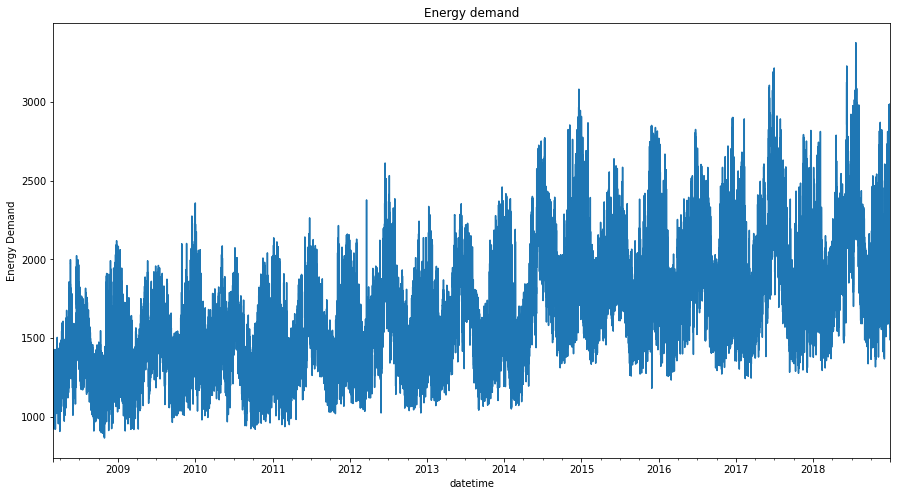

In [13]:
df1['energy'].plot(figsize = (15,8))
_ = plt.title('Energy demand')
_ = plt.ylabel('Energy Demand' )


### 3.1.1. Visualizing hourly demand on first and last day

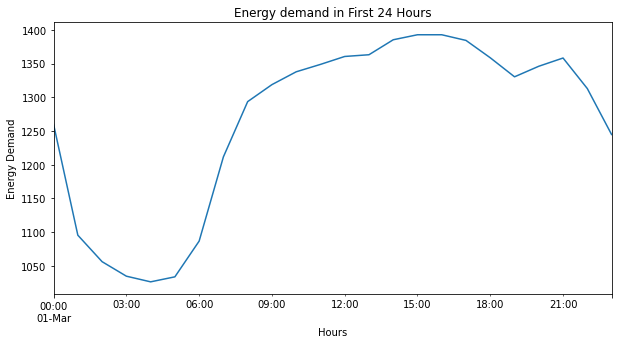

In [14]:
df1['energy'].first('24H').plot(figsize = (10,5))
_ = plt.title('Energy demand in First 24 Hours')
_ = plt.ylabel('Energy Demand' )
_ = plt.xlabel("Hours")

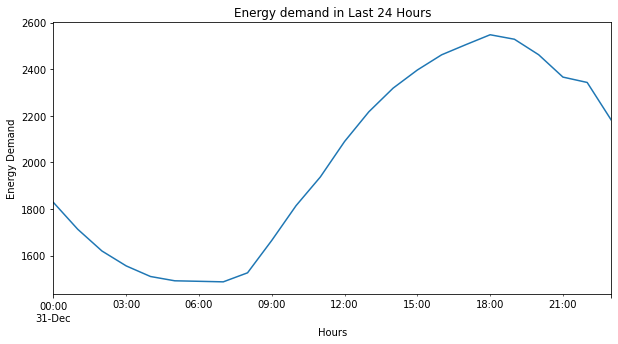

In [15]:
df1['energy'].last('24H').plot(figsize = (10,5))
_ = plt.title('Energy demand in Last 24 Hours')
_ = plt.ylabel('Energy Demand' )
_ = plt.xlabel("Hours")

We see that the hourlt trend has changed cnsiderably and there is significant difference in the maximum and minimum energy demands on the first and last day taken into consideration. This hints at an increasing energy demand over the years. We can verify the same further.

### 3.1.1  Visualizing Daily demand in first and last 7 days

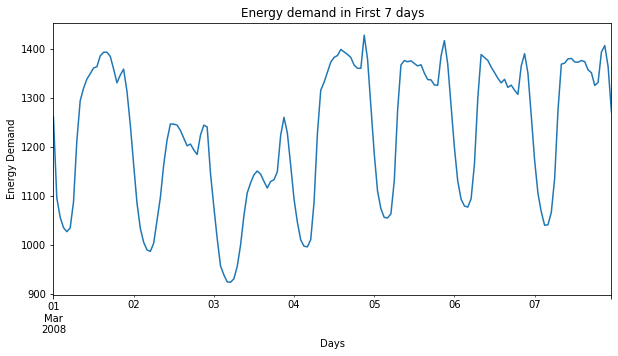

In [16]:
df1['energy'].first('7D').plot(figsize = (10,5))
_ = plt.title('Energy demand in First 7 days')
_ = plt.ylabel('Energy Demand' )
_ = plt.xlabel("Days")

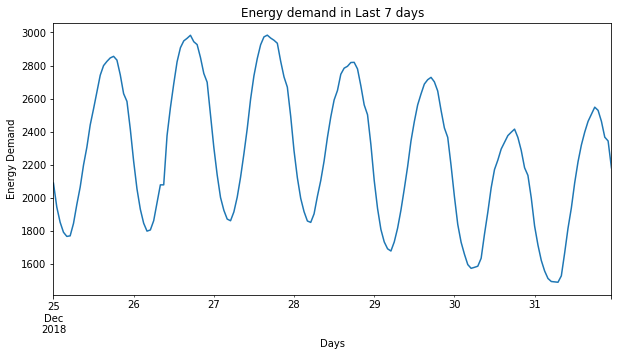

In [17]:
df1['energy'].last('7D').plot(figsize = (10,5))
_ = plt.title('Energy demand in Last 7 days')
_ = plt.ylabel('Energy Demand' )
_ = plt.xlabel("Days")

From  the above 2 plots we see that the sharp peaks in energy demand that occurs each day has smoothened over the years while the shape of the curve is preserved in the corresponding year.  There is a upward shift in minimum and maximum daily consumption

### 3.1.2 Visualizing weekly demand in first and last month

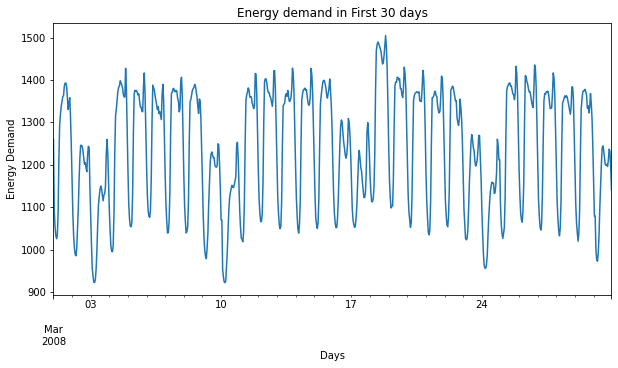

In [18]:
df1['energy'].first('30D').plot(figsize = (10,5))
_ = plt.title('Energy demand in First 30 days')
_ = plt.ylabel('Energy Demand' )
_ = plt.xlabel("Days")

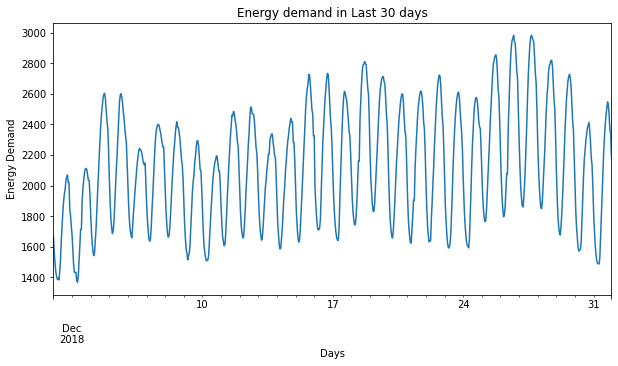

In [19]:
df1['energy'].last('30D').plot(figsize = (10,5))
_ = plt.title('Energy demand in Last 30 days')
_ = plt.ylabel('Energy Demand' )
_ = plt.xlabel("Days")

WE can see that the demadn has a well defined weekly periodicity during the initial phase of duration under consideration.

### 3.1.3 Visualizing monthly demand in the first and last year

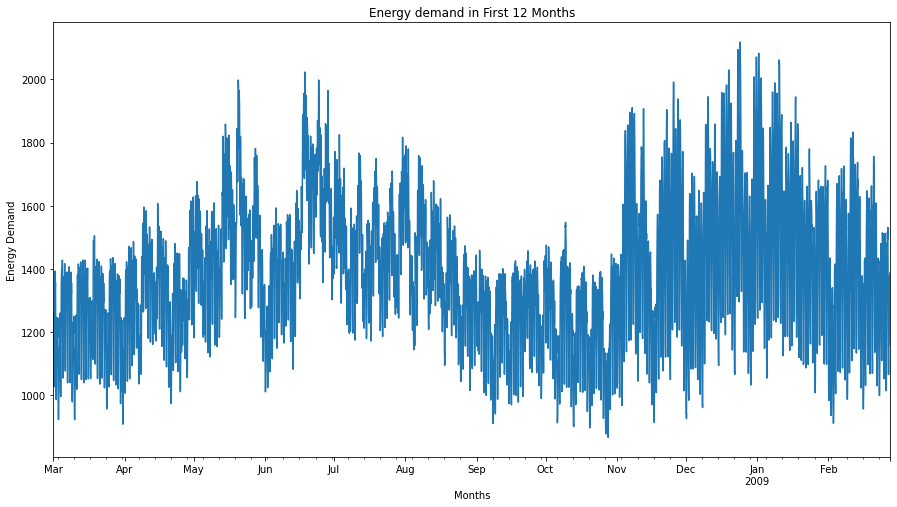

In [20]:
df1['energy'].first('12M').plot(figsize = (15,8))
_ = plt.title('Energy demand in First 12 Months')
_ = plt.ylabel('Energy Demand' )
_ = plt.xlabel("Months")

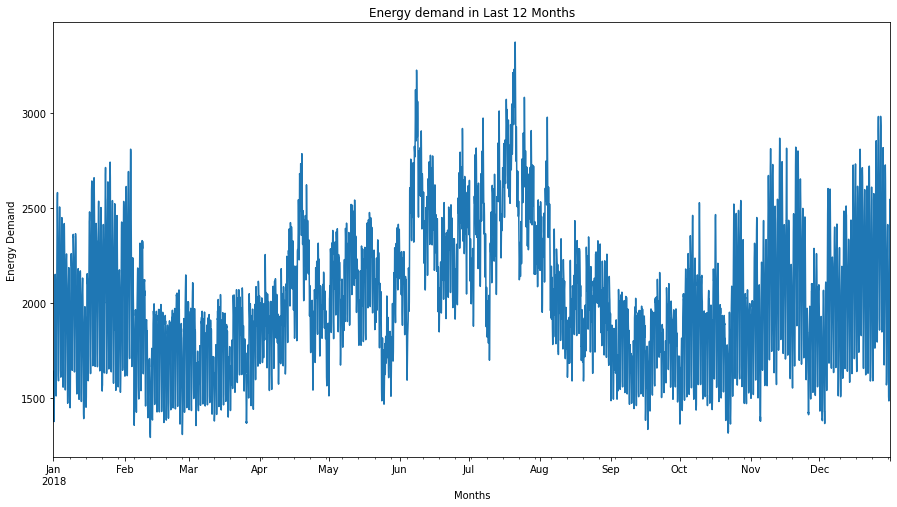

In [21]:
df1['energy'].last('12M').plot(figsize = (15,8))
_ = plt.title('Energy demand in Last 12 Months')
_ = plt.ylabel('Energy Demand' )
_ = plt.xlabel("Months")

We see that the demand peaks duing the same time in both periods considered

### 3.2.1 Plotting average hourly demand over the entire period 

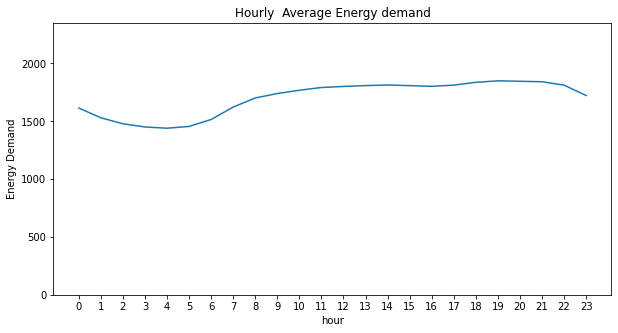

In [22]:
#Plotting average hourly load profile observed over the entire period 
df1.groupby('hour')['energy'].mean().plot(figsize = (10,5))
_ = plt.ylabel('Energy Demand' )
_ = plt.ylim([0, max(df1.groupby('hour')['energy'].mean()) + 500])
_ = plt.xticks(df1['hour'].unique())
_ = plt.title('Hourly  Average Energy demand')

* From the above average hourly load profile graph we can observe that the demand remains low  during the early hours of days and then increases and remains almost constant through out the rest of the day. Probably the given time is in UTC and if the time zone information is known, it is quite possible that the energy demand is at the lowest during night timedemand for when the entire counntry is asleep.


### 3.2.2 Plotting average monthly load profile

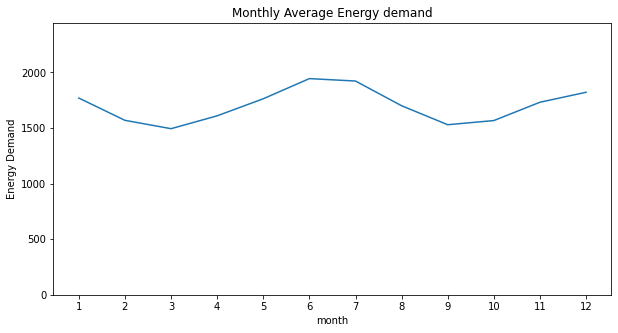

In [23]:
#Plotting average hourly load profile observed over the entire period 
df1.groupby('month')['energy'].mean().plot(figsize = (10,5))
_ = plt.ylabel('Energy Demand' )
_ = plt.ylim([0, max(df1.groupby('month')['energy'].mean()) + 500])
_ = plt.xticks(df1['month'].unique())
_ = plt.title('Monthly Average Energy demand')

* As expected the monthly demand profile peaks in certain seasons due to air-conditioning demcaused due to weather conditions 


### 3.2.3 Plotting a map of hourly vs weekdays energy demand 

In [24]:
#Using pivot table to create a dataframe having index as hours and columns as weekdays and each cell containing the average
#energy consumption for that particular hour of the weekday

hour_weekday = df1.pivot_table(values='energy', index='hour', columns = 'weekday', aggfunc = 'mean')

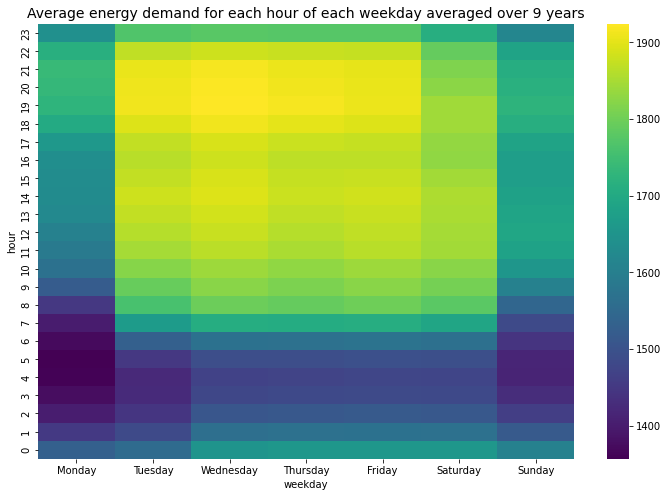

In [25]:
#plotting a heatmap with a colorbar
_ = plt.figure(figsize=(12, 8))
ax = sns.heatmap(hour_weekday.sort_index(ascending = False), cmap='viridis')
_ = ax.set_title("Average energy demand for each hour of each weekday averaged over 9 years", fontsize = 14)

* It can be seen that the average demand from Tuesday to Saturday is below 1700 between 11:00 PM and 7:00 AM. It increases during the day and is at peak (>1900) during the evening time before sliding down again. And on the weekends the same pattern can be observed but the overall demand seems lower on weekends than weekdays as expected, because most of the commercial buildings don't operate on weekends. 
* Also from all the above graphs it can be seen that the demand in the evening  is considerably higher than the rest of the day consumption. The reason for this, can be either time zone information is not exactly known, or that people usually return home from work during evening hours and the demand increases due to the turning on of electronic appliances like lights, TV, computers, air conditioning, etc. 


### 3.3.1 Plotting a histogram to see the overall distribution of the energy demand 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


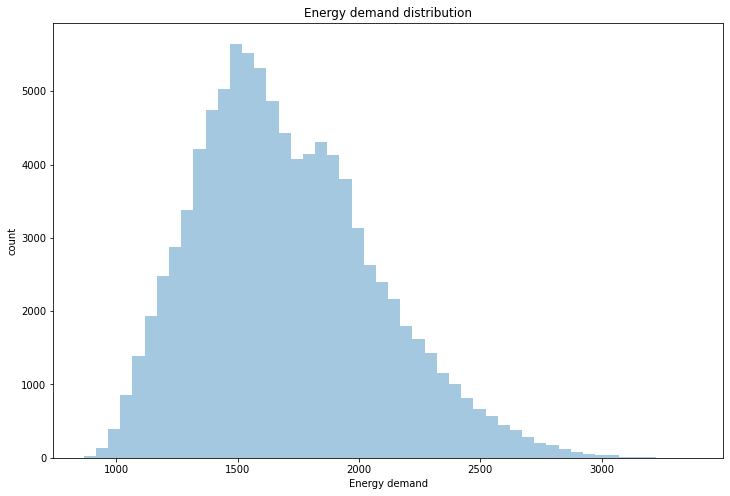

In [26]:
_ = plt.figure(figsize = (12,8))
_ = sns.distplot(df1['energy'], kde=False)
_ = plt.title('Energy demand distribution')
_ = plt.xlabel('Energy demand')
_ = plt.ylabel('count')

* It can be seen that most of the days (for 2014-18) have energy demand
between ~1300 to ~1800 and the maximum demand is around ~1500.

### 3.3.2 Plotting the distribution using box plot and dividing the columns of the plot by weekdays and adding a hue for holidays

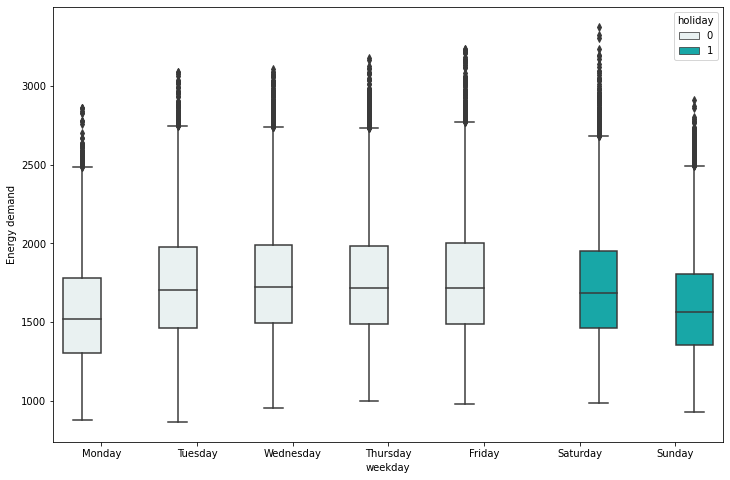

In [27]:
_ = plt.figure(figsize = (12,8))
_ = sns.boxplot(x = 'weekday', y = 'energy', data = df, color='c', hue='holiday')
_ = plt.ylabel('Energy demand')

* It can be seen that the median energy consumption on working days remains fairly same from Tuesday to Saturday and drops on Monday and Sunday as seen before in the heatmap. The outliers on the higher side is little higher on Saturday, which my be beacuse of social reasons. 


In [28]:
#Seems like the holidays are on Sunday and Monday, so let's redefine the column.
df1['holiday']=df1['weekday'].apply(lambda x: 1 if x  in ['Monday', 'Sunday'] else 0)
df1.head()

,energy,Date,year,month,day,hour,weekday,holiday
datetime,,,,,,,,
2008-03-01 00:00:00,1259.985563,2008-03-01,2008,3,1,0,Saturday,0
2008-03-01 01:00:00,1095.541500,2008-03-01,2008,3,1,1,Saturday,0
2008-03-01 02:00:00,1056.247500,2008-03-01,2008,3,1,2,Saturday,0
2008-03-01 03:00:00,1034.742000,2008-03-01,2008,3,1,3,Saturday,0
2008-03-01 04:00:00,1026.334500,2008-03-01,2008,3,1,4,Saturday,0


## 3.3.3 Visualizing the distribution of energy values for different years

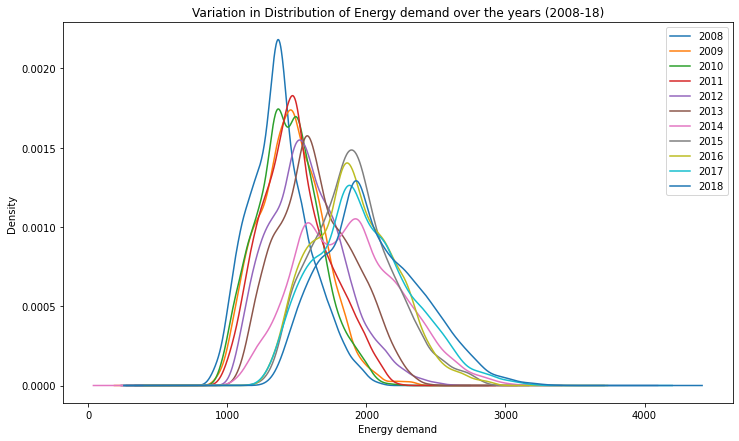

In [29]:
for year in df1['year'].unique():
    df1[df1['year'] == year]['energy'].plot(kind='density', figsize = (12,7), legend = True, label = year)
_ = plt.xlabel('Energy demand')
_ = plt.title('Variation in Distribution of Energy demand over the years (2008-18)')

* For some years the distribution is kind of bi-modal and the mode values for energy demand shift towards right (towards higher energy demand) each year from 2008 to 2018. 


### 3.4 Plotting maximum peak demands in a month over the years.

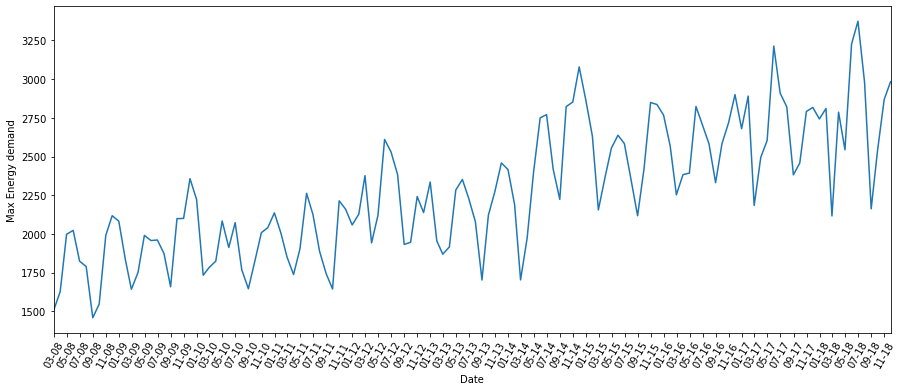

In [30]:
# Resampling the energy data monthly and calculating the max energy demand for each month
monthly_en = df1.resample('M', label = 'left')['energy'].max()
_ = plt.figure(figsize = (15,6))
#plotting the max monthly energy demand
_ = plt.plot(monthly_en)
# ensuring the limits on x axis to be between the dataframe's datetime limits
_ = plt.xlim(monthly_en.index.min(), monthly_en.index.max())
# Using matplotlib MonthLocator to be used in the xticks to mark individual months
locator = mdates.MonthLocator(bymonthday = 1, interval = 2)  # every 2 months 
fmt = mdates.DateFormatter('%m-%y')  # xticks to be displayed as 01-14 (i.e. Jan'14) and so on
X = plt.gca().xaxis
# Setting the locator
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
_ = plt.xticks(rotation = 60)
_ = plt.ylabel('Max Energy demand')
_ = plt.xlabel('Date')


* The maximum monthly peak demand seems to have been increasing gradually over the years.


def plot_ts_pred(og_ts, pred_ts, model_name=None, og_ts_opacity = 0.5, pred_ts_opacity = 0.5):
    """
    Plot plotly time series of the original (og_ts) and predicted (pred_ts) time series values to check how our model performs.
    model_name: name of the model used for predictions
    og_ts_opacity: opacity of the original time series
    pred_ts_opacity: opacity of the predicted time series
    """
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = og_ts.index, y = np.array(og_ts.values), name = "Observed",
                         line_color = 'deepskyblue', opacity = og_ts_opacity))

    try:
        fig.add_trace(go.Scatter(x = pred_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))
    except: #if predicted values are a numpy array they won't have an index
        fig.add_trace(go.Scatter(x = og_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))


    #fig.add_trace(go)
    fig.update_layout(title_text = 'Observed test set vs predicted energy values using {}'.format(model_name),
                  xaxis_rangeslider_visible = True)
    fig.show()

## 4. Analysing Time series structure, Stationarity and Auto Correlation 
### 4.1 Decomposing the time series data

datetime
2008-03-01 00:00:00   -347.246203
2008-03-01 01:00:00   -424.697823
2008-03-01 02:00:00   -475.635315
2008-03-01 03:00:00   -500.634441
2008-03-01 04:00:00   -511.391436
Name: seasonal, dtype: float64


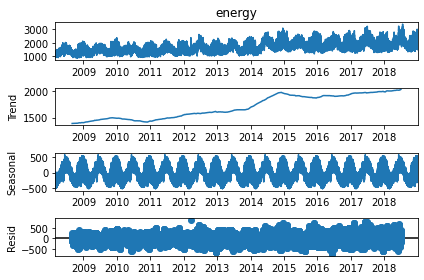

In [31]:
# Run seasonal decompose
decomp = sm.tsa.seasonal_decompose(df1['energy'], period=24*365) # capturing the yearly seasonal component;
print(decomp.seasonal.head()) # checking the seasonal component
_ = decomp.plot()

* The trend shows how the energy demand increases over the years from 2008-18.
* The seasonal component captures the summer and winter trends very well too. 

### 4.2 Analysing Stationarity 

* The simplest way to identify stationarity (or its absence) is viewing the data as we did above by decomposing it but the most common way of testing a dataset for stationarity is the __Dicky Fuller test__ which tests for a unit root. Basically, if the p-value of the test is too small (say less than 0.05, giving us 95% confidence) then we reject the hypothesis that our data is non-stationary and assume that it is stationary indeed.

* The most common way of dealing with stationarity is differencing our dataset. 

#### 4.2.1 Differencing

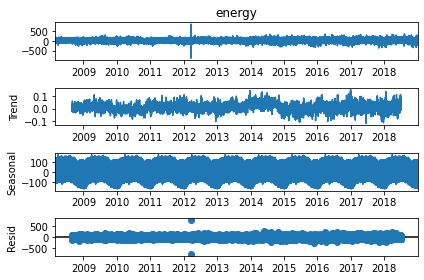

In [32]:
# Differencing the data once
decomp_diff1 = sm.tsa.seasonal_decompose(df1['energy'].diff().dropna(), period=24*365) 
_ = decomp_diff1.plot()

* Comparing the above differenced plot with the previous original data plot we can see how the trend was removed by differencing just once and also the effect of seasonality was also reduced.
* To deal with seasonality we can difference the dataset with the periodicity of the seasons. Let's difference the dataset by its smallest period which is 24 hours here. 

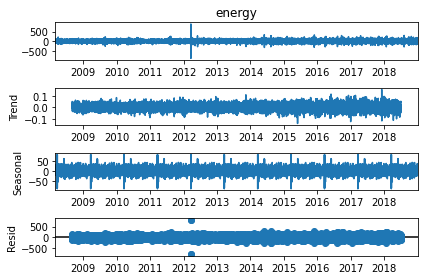

In [33]:
# Differencing the data with periodicity of 24 hours in addition to the original single differencing

decomp_diff24 = sm.tsa.seasonal_decompose(df1['energy'].diff().dropna().diff(24).dropna(), period=24*365) 
_ = decomp_diff24.plot()


* Differencing the dataset once and then with the period of 24 hours further diminishes any trend and seasonality effects and seems to render the dataset stationary.

#### 4.2.2 Conducting the Dicky Fuller test of Stationarity

In [34]:
def run_adfuller(ts):
    result = adfuller(ts)
    print("t-stat", result[0])
    print("p-value", result[1])
    print("#lags used", result[2])
    print("critical values", result[4]) 

In [35]:
print("for no differencing\n")
run_adfuller(df1['energy'])
print("\nfor single differencing\n")
run_adfuller(df1['energy'].diff().dropna())
print("\nfor differenced data set over lags 24 after single differencing\n")
run_adfuller(df1['energy'].diff().dropna().diff(24).dropna())

for no differencing

t-stat -9.218570739447475
p-value 1.8057242790624026e-15
#lags used 67
critical values {'1%': -3.4304188917117377, '5%': -2.8615704490393217, '10%': -2.5667862069612752}

for single differencing

t-stat -56.54743188762409
p-value 0.0
#lags used 67
critical values {'1%': -3.4304188924375216, '5%': -2.861570449360103, '10%': -2.5667862071320164}

for differenced data set over lags 24 after single differencing

t-stat -54.44794296166258
p-value 0.0
#lags used 67
critical values {'1%': -3.4304189098609217, '5%': -2.8615704570608784, '10%': -2.5667862112308866}


* Based on the p-values of the above tests it looks like, our original dataset has already been stationary but if we check the t-stat values it is obvious that the stationarity gets more significant with differencing.  So, we can either use the original dataset as it is with the time series models , or to be more robust we can use the single differencing to remove the trend and fit our models on the detrended data. 

### 4.3. Correlation with the past values


The correlation of the time series observations calculated with values of the same series at previous times, is called a serial correlation, or an autocorrelation (ACF). It is used to determine the moving average (MA or q) term of the ARIMA(p,d,q) models.

A partial autocorrelation (PACF) is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed. It is used to determine the auto regression (AR or p) term of the ARIMA(p,d,q) models.

And we have observed till now that our energy demand time series has a strong correlation with its past day value (lag of 24 hours) and also its past value 365*24 hours ago. In addition a weekly seasonality is also observed in the energy consumption. Let's plot the ACF and PACF plots for our energy time series data to check the same.

#### Plotting the ACF and PACF plots

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [37]:
def acf_pacf_plots(ts, lags, figsize = (12,8)):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = figsize)
    
    # Plot the ACF of ts
    _ = plot_acf(ts, lags = lags, zero = False, ax = ax1, alpha = 0.05)

    # Plot the PACF of ts
    _ = plot_pacf(ts, lags = lags, zero = False, ax = ax2, alpha = 0.05)

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


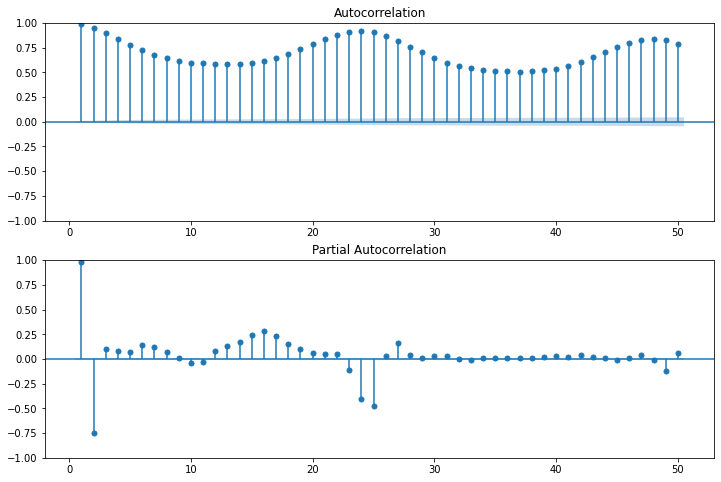

In [38]:
# Create the acf and pacf plots

dfacf = []
dfacf = df1['energy']
lags = 50

acf_pacf_plots(dfacf, lags = lags, figsize = (12,8))

The seasonal period of 24 hours can be easily observed from the plots above.

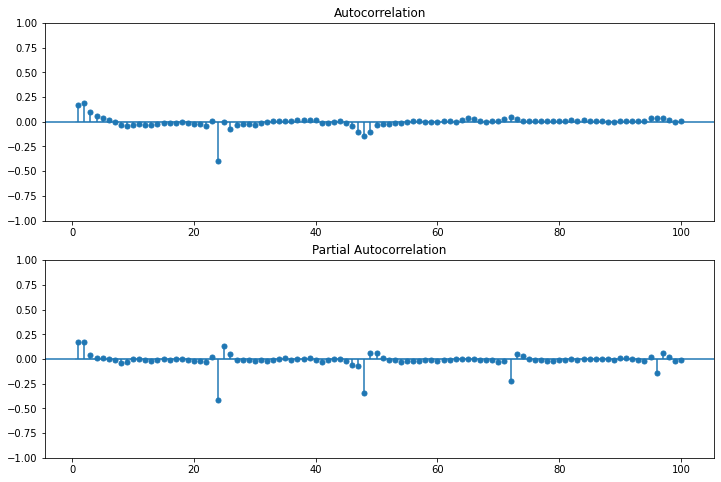

In [39]:
# Differencing the data this time to remove the trend and seasonality
dfacf = []
dfacf = df1['energy']
dfacf = dfacf.diff().dropna() 
dfacf = dfacf.diff(24).dropna()
dfacf = dfacf.diff(24*365).dropna()
lags = 100

acf_pacf_plots(dfacf, lags = lags, figsize = (12,8))

Even after differencing and seasonal differencing the data, the ACF and PACF plots are not very informative, they do not tell us which AR and MA terms will be good for the SARIMAX model (S stands for seasonality and X for exogenous variables).

This is a common pitfall of the ACF, PACF plots and SARIMAX models. They cannot handle multiple seasonality. And our energy demand dataset has multiple seasonalities - daily (24 hours), weekly (168hours), yearly (24*365.25).  So, we shall use alogrithms that can handle multiple seasonlaity

***
##  Handling Multiple seasonality <a name="6.2"></a>
***

 We shall use FB Prophet, a robust algorithm used for building models that could handle multiple seasonality effectively
 
## 5. Model Building
### 5.1. Data Preparation

Prophet requires the input data in a particular format, so preparing the data for Prophet.

In [40]:
test_index = int(len(df1)*0.85)# (test size = .15 * len(df)

        
X_trainP = df.drop('energy', axis = 1).iloc[:test_index]
y_trainP = df.energy.iloc[:test_index]
X_testP = df.drop('energy', axis = 1).iloc[test_index:]
y_testP = df.energy.iloc[test_index:]

# preparing data for Prophet
def data_prophet(X_train, X_test, y_train, y_test):
    data_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
    data_train = data_train.reset_index().rename(columns = {'energy':'y', 'datetime':'ds'})
    data_test = pd.merge(X_test, y_test, left_index=True, right_index=True)
    data_test  = data_test.reset_index().rename(columns = {'energy':'y', 'datetime':'ds'})
    return data_train, data_test

In [41]:
data_train, data_test = data_prophet(X_trainP, X_testP, y_trainP, y_testP)
data_train.tail(3)

,index,row_id,ds,Date,year,month,day,hour,weekday,holiday,y
80740,80740,80741,2017-05-17 04:00:00,2017-05-17,2017,5,17,4,Wednesday,0,1968.7266
80741,80741,80742,2017-05-17 05:00:00,2017-05-17,2017,5,17,5,Wednesday,0,2013.0147
80742,80742,80743,2017-05-17 06:00:00,2017-05-17,2017,5,17,6,Wednesday,0,2117.7072


In [42]:
data_test.head(3)

,index,row_id,ds,Date,year,month,day,hour,weekday,holiday,y
0,80743,80744,2017-05-17 07:00:00,2017-05-17,2017,5,17,7,Wednesday,0,2299.0473
1,80744,80745,2017-05-17 08:00:00,2017-05-17,2017,5,17,8,Wednesday,0,2392.8264
2,80745,80746,2017-05-17 09:00:00,2017-05-17,2017,5,17,9,Wednesday,0,2375.3142


In [ ]:
!pip install git+https://github.com/stan-dev/pystan2.git@master
!pip install fbprophet

### 5.2 Training the Model

In [44]:
# Importing Prophet
from fbprophet import Prophet

In [45]:
# Initiating fbprophet model; set the uncertainty interval to 95% (the Prophet default is 80%)
prop = Prophet(growth='linear', interval_width = 0.95, 
                yearly_seasonality='auto',
                weekly_seasonality='20',
                daily_seasonality='auto',
                seasonality_mode='multiplicative',
                seasonality_prior_scale = 12
              )

* We can add the seasonalities separately in the Prophet model by replacing the 'auto' mode of the seasonalities above with 'FALSE'. Then we can add the yearly, weekly, daily, monthly, quarterly, etc. seasonalities using the .add_seasoanlity feature of the Prophet specifying the period in days for a seasonality along with the fourier terms to be used and the prior_scale to set. 
* After some trial and error seasonality values were set.Weekly is given more importance as , the default model did not capture the weekly seasonality.
* There are two mode options for any seasonality - 'additive' or 'multiplicaitve'. Multiplicaitve should be used if the seasonality affects the trend exponentially. 


In [46]:
prop.add_regressor('holiday', mode='multiplicative') 

In [47]:
# Fitting the model to training data
prop.fit(data_train)

Initial log joint probability = -353.192
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        197240    0.00219352       21925.9      0.7871      0.7871      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        198284     0.0184843       7242.31           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        198794     0.0213192       3329.96           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        198886    0.00154884       1010.76           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        199035    0.00341222       2254.36           1           1      589   
    Iter      log prob        ||dx||      ||grad||       alpha  

1030.25           1           1     1938   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1799        199348    0.00220817       533.725           1           1     2053   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1899        199351    0.00201093       365.936        0.91       0.091     2176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1999        199352    0.00216172       513.125        3.86       0.386     2292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2099        199356    0.00201469       1846.02           1           1     2411   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2199        199367   0.000193728       377.573           1           1     2521   
    Iter      log prob        ||dx||      ||grad||       alph

### 5.3. Evaluating the model

In [48]:
forecast = prop.predict(df=data_test.reset_index())

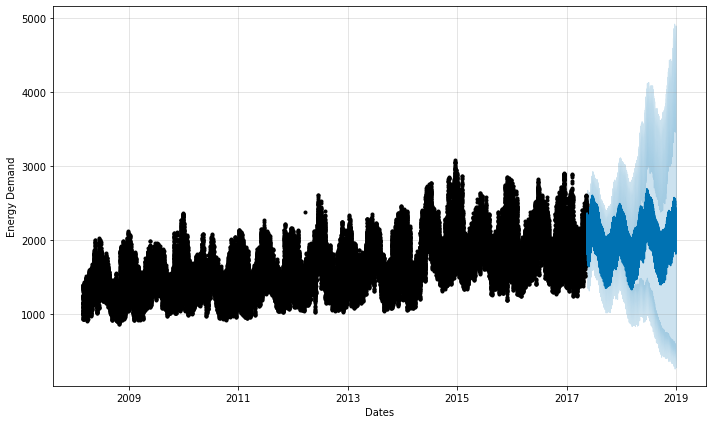

In [49]:
_ = prop.plot(forecast, uncertainty = True, xlabel = 'Dates', ylabel = 'Energy Demand')

/opt/conda/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/opt/conda/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/opt/conda/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


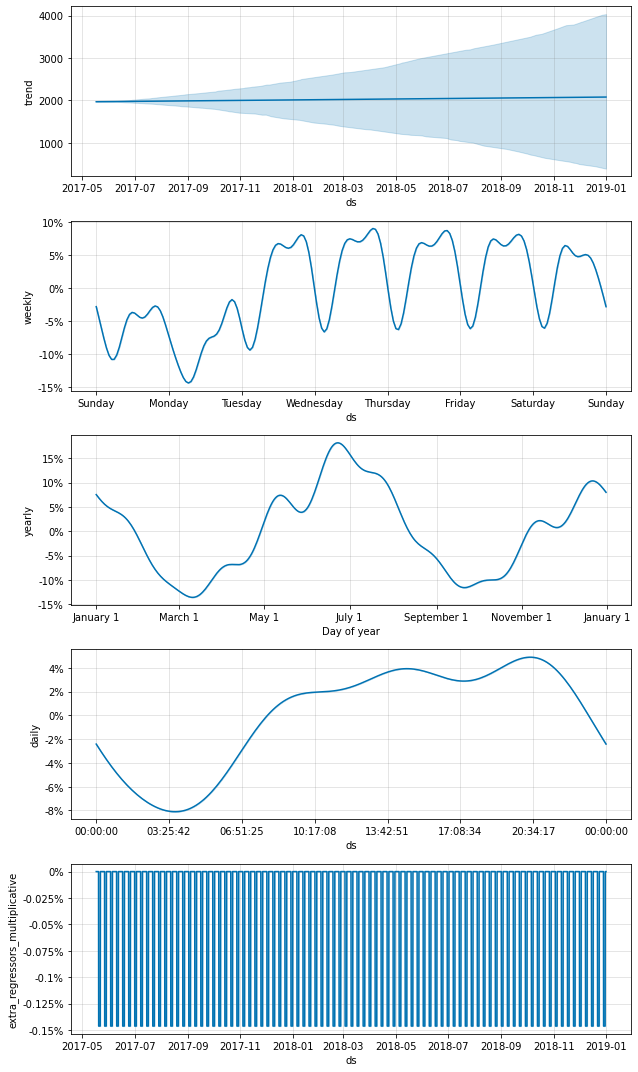

In [50]:
_ = prop.plot_components(forecast)

* We can see that the multiple seasonalities were captured very well by the Prophet model. 
* In the bottom most plot, the extra regressor additve terms include the temperature, non_working_working and cum_AC_kW variables. 

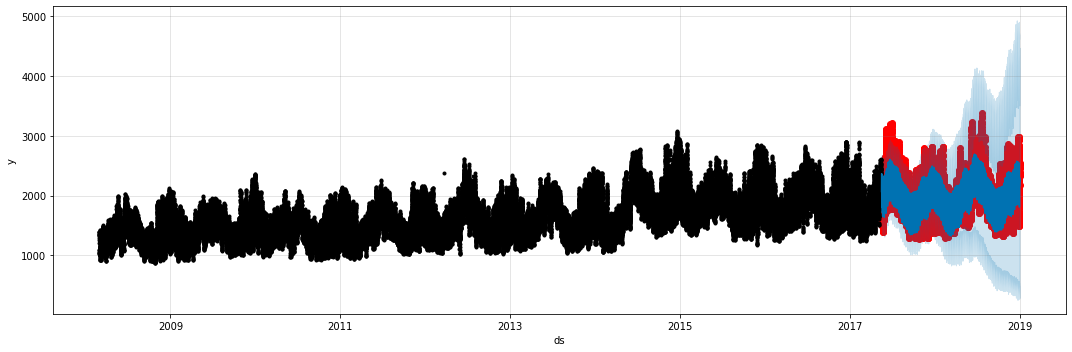

In [51]:
#Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_test['ds'], data_test['y'], color='r')
fig = prop.plot(forecast, ax=ax)


In [52]:
mean_squared_error(y_true=data_test['y'], y_pred=forecast['yhat'])

50441.2334135642

In [53]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=data_test['y'], y_pred=forecast['yhat'])

8.286834978586091

### 5.4. Prediction

In [54]:
test=pd.read_csv('../input/forecast-green-energy/test_WudNWDM.csv')
test.head()

,row_id,datetime
0,94993,2019-01-01 00:00:00
1,94994,2019-01-01 01:00:00
2,94995,2019-01-01 02:00:00
3,94996,2019-01-01 03:00:00
4,94997,2019-01-01 04:00:00


In [55]:
df_test=pd.DataFrame({})
weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}
df_test['datetime'] = pd.to_datetime(test.datetime)
df_test['Date'] = pd.to_datetime(df_test.datetime.dt.date)
df_test['weekday'] = df_test.datetime.dt.weekday.map(weekdays)
df_test['holiday']=df_test['weekday'].apply(lambda x: 1 if x  in ['Monday', 'Sunday'] else 0)
df_test.head()

,datetime,Date,weekday,holiday
0,2019-01-01 00:00:00,2019-01-01,Tuesday,0
1,2019-01-01 01:00:00,2019-01-01,Tuesday,0
2,2019-01-01 02:00:00,2019-01-01,Tuesday,0
3,2019-01-01 03:00:00,2019-01-01,Tuesday,0
4,2019-01-01 04:00:00,2019-01-01,Tuesday,0


In [56]:
df_test =  df_test.rename(columns = {'datetime':'ds'})
df_test = df_test[['ds','holiday']]
df_test.head()

,ds,holiday
0,2019-01-01 00:00:00,0
1,2019-01-01 01:00:00,0
2,2019-01-01 02:00:00,0
3,2019-01-01 03:00:00,0
4,2019-01-01 04:00:00,0


In [57]:
forecast = prop.predict(df=df_test)

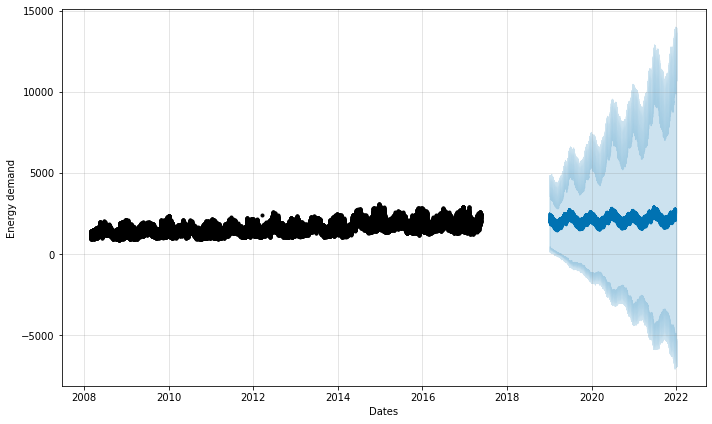

In [58]:
_ = prop.plot(forecast, xlabel = 'Dates', ylabel = 'Energy demand')

In [59]:
predicted=forecast[['ds','yhat']]

In [60]:
test.datetime=pd.to_datetime(test.datetime)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    26304 non-null  int64         
 1   datetime  26304 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 411.1 KB


In [61]:
sub = test[['row_id','datetime']].merge(predicted,how='inner',left_on='datetime', right_on='ds')
sub.head()

,row_id,datetime,ds,yhat
0,94993,2019-01-01 00:00:00,2019-01-01 00:00:00,2062.337269
1,94994,2019-01-01 01:00:00,2019-01-01 01:00:00,1970.025585
2,94995,2019-01-01 02:00:00,2019-01-01 02:00:00,1906.356862
3,94996,2019-01-01 03:00:00,2019-01-01 03:00:00,1880.081528
4,94997,2019-01-01 04:00:00,2019-01-01 04:00:00,1895.639533


In [62]:
sub =  sub.rename(columns = {'yhat':'energy'})
sub[['row_id','energy']].to_csv('submission.csv',index=False)
